# Fermion Chain to Boson Chain

Here we solve a thigh-binding model by using th Jordan-Wigner transformations to represent Fermion operators in Qutip. THe examples are:
- Two-Fermions for both gaussian an localized initial states
- Single fermion initially localized 
- Single fermion initially gaussian


To properly work with Qutip we have to figure out how to incorporate fermions since there is no dedicated operator for that in this toolbox. There are however boson operators. Therefore **we can just use Jorda-Wigner transforms to express our fermionic operators (even with spins, we have to figure that one out) in terms of the JW string times a bosonic operator**. This is what we do here. **There is already a function that does this called fdestroy() or fcreate()**.

Notice how here since we have spins, at each site the particle can be either spin up or spin down, therefore the local hilbert space dimension is 2, which means that the Hamiltonian will be of size 2Lx2L.



In [210]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from qutip import  *


In [3]:
def create_fermion_op(Nsites, bop):
    # ------------------------------------------------------
    # DEPRECATED BECAUSE IT DOES THE SAME AS THE QUTIP fcreate
    # ------------------------------------------------------
    
    # create fermions from quspin bosons and JW strings
    # bop is the boson operator
    # this does exactly the same as fdestroy
    C_list = []
    for site_j in range(0, Nsites):
        # create the string
        JW_string = [identity(2)]*Nsites
        for l in range(0,site_j):
            JW_string[l] = (1j*np.pi*bop.dag()*bop).expm()
        JW_string[site_j] = bop
        # tensor product the string to get the new fermion operator at site_j
        C_list.append(tensor(JW_string))
    return C_list


def gen_gauss_init(l0, sigma, Nsites, k0=0):
    # creates a gaussian initial condition centerd on l0 with bandwidth sigma for Nsites
    # and initial velocity k0

    x = np.asarray(range(0,Nsites))
    coefs = ((np.sqrt(np.pi)*sigma)**(-0.5))*np.exp(-0.5*(x-l0)**2/(sigma)**2 )*np.exp(1j*k0*(x-l0))
    
    return coefs    
    
def get_1p_basis(Nsites):
    # creates the initial wave function from the init_coefs list
    # and the one particle basis vectors
    # create the density matrix from ONE particle basis states
    # list holding all possible 1-particle states
    string_list = []
    basis_list = []
    
    for site_j in range(0,Nsites):
        # create emty sites
        site_vectors = [basis(2, 0)]*Nsites
        site_string = [0]*Nsites
        
        # create an exitation at site j
        site_vectors[site_j] = basis(2, 1)
        site_string[site_j] = 1
        
        string_list.append(site_string)
        basis_list.append(tensor(site_vectors))

    return string_list, basis_list

def get_2p_basis(Nsites):
    #creates a two particle basis for a lattices of size Nsites
    
    string_list = [] # to track where we put the particles
    basis_list = [] # to save the multiparticle basis states
    for site_i in range(0,L-1):
        for site_j in range(site_i+1,L):
            site_string = [0]*Nsites
            site_vectors = [basis(2, 0)]*Nsites
            # place a fermion in site o and another in j
            site_vectors[site_i] = basis(2, 1)
            site_vectors[site_j] = basis(2, 1)
            # track the placement as a string
            site_string[site_i] = 1
            site_string[site_j] = 1

            basis_list.append(tensor(site_vectors))
            string_list.append(site_string)

    return string_list,basis_list

def get_initial_state(init_coefs, basis_set):
    # creates the initial Psi0 state by combining the lists init_coefs and basis_set
    # into a normalized qutip ket
    
    Psi0 = np.sum([init_coefs[j]*basis_list[j] for j in range(0,len(init_coefs))])
    Psi0 = Psi0.unit()
    
    return Psi0

def get_thight_binding_hamiltonian(op_list, Nsites,jcouple, bc="fixed"):
    # creates the tight binding hamiltonian  from the fermion operators in op_list
    # and the coupling array jcouple with the chosen boundary conditions
    # for Nsites lattices sites

    ident_tensor = tensor([identity(2)]*(Nsites)) 
    H = 0*ident_tensor

    for site_j in range(0,Nsites-1):
        H += -0.5*jcouple[site_j]*(op_list[site_j].dag()*op_list[site_j+1]+op_list[site_j+1].dag()*op_list[site_j])
        
    if bc == "periodic":
        print("periodic")
        # operator that acts on the final 
        # implement periodic boundaries
        H += -0.5*jcouple[Nsites-1]*(op_list[Nsites-1].dag()*op_list[0]+op_list[0].dag()*op_list[Nsites-1])
        
    return H 

    
def create_lindblad_op(Nsites, operator_list ,collapse_type="number"):
    # creates the operators necesary for the non-unitrary dynamics i.e
    # collapse operatos and the operators for the expectation values
    # collapse_type = "number" or "ladder"
    collapse_ops = []
    expect_ops = []

    for site_j in range(0,Nsites):
        density_op = operator_list[site_j].dag()*operator_list[site_j]
        expect_ops.append(density_op)
        
        if collapse_type=="number":
            collapse_ops.append(np.sqrt(gamma)*density_op)
        else: 
            collapse_ops.append(np.sqrt(gamma)*operator_list[site_j])
    
    return collapse_ops, expect_ops



### The double Gaussian is tricky:

If we go around carelesly summing up the gaussians and pairing that with the basis we find a problem: The double gaussian is as long as the lattice, but the basis has more elements (all possible pairings of 2 particles along the lattice). 

The correct way to go around it is to notice that the probability of finding the two particles in a given configuration, say 10001 is equak to the probability of finding particle 1 in site 1 and particle 2 in site 5 **but here we are making the crucial assumptions that the probas for each particle are independent**, otherwise we would not be able to factorize the probability distribution. Therefore the coefficient for each basis state (representing the 2 particle configuration) should be a product of the gaussian probabilities of each particle

**This necessitates that the wave packets are well sepparated (no overlaps) in the initial condition***

In [212]:
def gen_double_gauss(config_string, sigma, Nsites, k0=0):
    # create two gaussians with badnwidth sigma centered around the two
    # sites marked in the config_string

    x = np.asarray(range(0,Nsites))
    config_arr = np.asarray(config_string)
    
    indices_ = np.where(config_arr == 1)[0]
    # for particle 1
    gauss1 = ((np.sqrt(np.pi)*sigma)**(-0.5))*np.exp(-0.5*(x-indices_[0])**2/(sigma)**2 )*np.exp(1j*k0*(x-indices_[0]))
    # for particle 2
    gauss2 = ((np.sqrt(np.pi)*sigma)**(-0.5))*np.exp(-0.5*(x-indices_[1])**2/(sigma)**2 )*np.exp(1j*k0*(x-indices_[1]))
    
    coefs = []
    # follow the same order as the basis creation
    for site_i in range(0,L-1):
        for site_j in range(site_i+1,L):
            coefs.append(gauss1[site_i]*gauss2[site_j])
        
    return np.asarray(coefs), gauss1+gauss2


# Two particles

In [245]:
L = 8
gamma = 0.1 # the dephasing term for the collapse operators
max_t = 40 # maximum time
tsteps = 200 # number of time steps
J = np.ones(L) # interaction
J_contact = 1.0
boundaries = "fixed" #
band_width = 0.3 # bandwidth of wave packet if gauss. Higher number means less localized
wave_packet = True
K0 = 0.9

# Here we could place a a point contact if we want
J[L-4] = J_contact
#J[L-3] = J_contact
collapse_op = "number" # either "number" or "ladder"
# this one chooses where to place the particles
# due to basis ordering here 0 is 110...0 and the index L-2 corresponds to 10...01
centered_in = L-4

# the vaccum is basis(2,0)
fdestroy(1,0).dag()*fdestroy(1,0)*basis(2,1)


Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]]

chosen initial configuration: 
[1, 0, 0, 0, 0, 1, 0, 0]


Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]], shape=(256, 256), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.  -0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  0.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.  -0.5  0. ]
 [ 0.   0.   0.  ... -0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]]

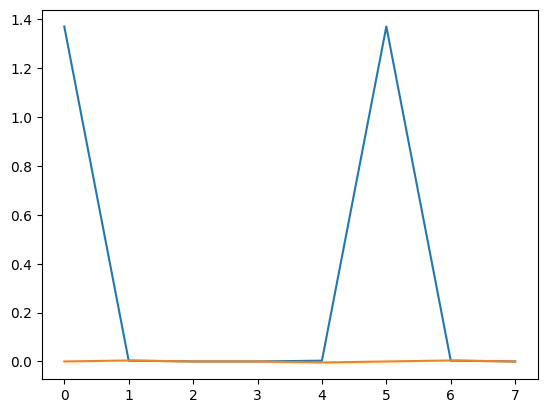

In [246]:
# create the basis and the coeficients for the initial state

str_list, basis_list = get_2p_basis(L)

if wave_packet==True:
    initial_condition, init_dist = gen_double_gauss(str_list[centered_in], band_width, L, k0=K0)
    
else:
    initial_condition = np.zeros(len(basis_list))
    initial_condition[centered_in] = 1

plt.plot(init_dist.real)
plt.plot(init_dist.imag)

print("chosen initial configuration: ")
print(str_list[centered_in])

psi0 = get_initial_state(initial_condition,basis_list)
rho = ket2dm(psi0) # initial density matrix

# create the fermion operator list
c_list = [fdestroy(L,i) for i in range(0,L)]

# create the hamiltonian
H = get_thight_binding_hamiltonian(c_list, L,J, bc=boundaries)

# get the operators needed for lindbladian 
collapse_ops, expect_ops = create_lindblad_op(L, c_list ,collapse_op)
# add the energy to also track it
expect_ops.append(H)

H

In [247]:
times = np.linspace(0.0, max_t, tsteps)
result = mesolve(H, rho, times, c_ops=collapse_ops , e_ops=expect_ops)

result

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 6.914138793945312e-05
    preparation time: 0.0010080337524414062
    run time: 1.8285787105560303
    solver: 'Master Equation Evolution'
    num_collapse: 8
  Time interval: [0.0, 40.0] (200 steps)
  Number of e_ops: 9
  State not saved.
>

Text(0, 0.5, 'Energy')

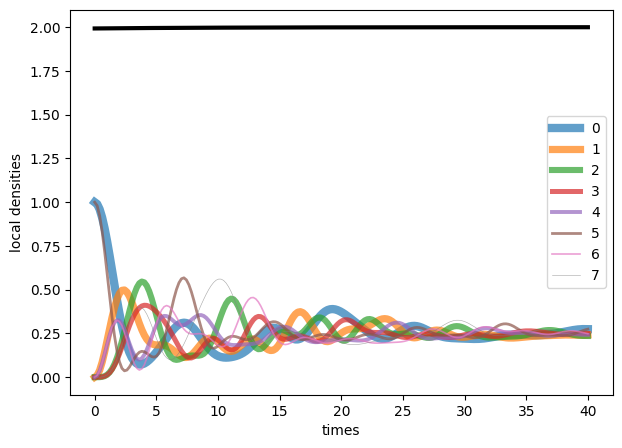

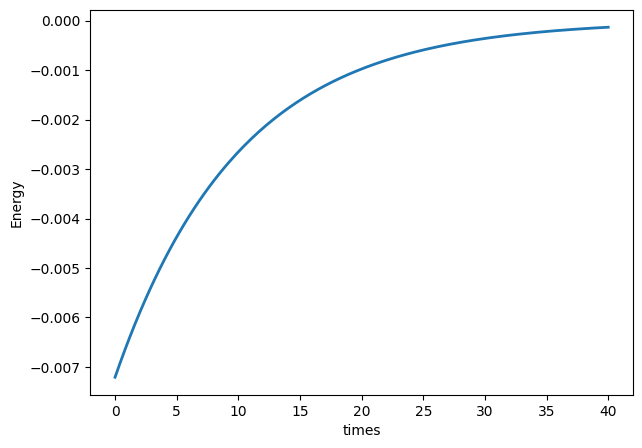

In [248]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# plot
for i in range(0,len(result.expect)-1):
    ax.plot(times, result.expect[i], linewidth=6.0-(0.8*i), label=i, alpha=0.7)
    
# get the total particle number
# get the sum of the local densities
n_tot = np.sum(result.expect, axis=0)
ax.plot(times, n_tot, c='black', linewidth=3.0)

ax.set_xlabel("times")
ax.set_ylabel("local densities")
plt.legend()


fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(times, result.expect[-1], linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("Energy")


Text(50.722222222222214, 0.5, 'densities')

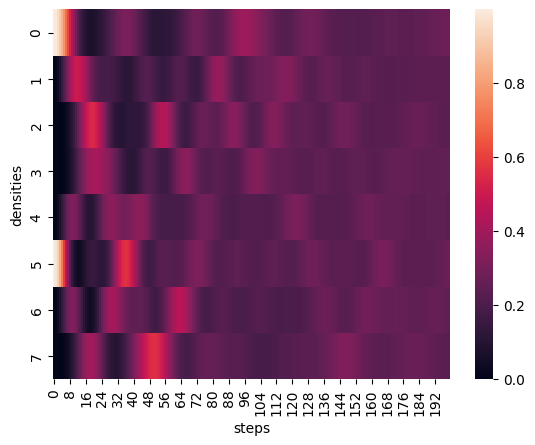

In [249]:
xt = np.linspace(0,max_t,5)
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1])
ax.set_xlabel("steps")
ax.set_ylabel("densities")

#plt.savefig("../plots/trajectory_L={}_Jc={}.png".format(L,J_contact), dpi=300)


# Single Localized particle

In [166]:
L = 2 # Num of sites
gamma = 0.1 # the dephasing term for the collapse operators
max_t = 40 # maximum time
tsteps = 200 # number of time steps
J = np.ones(L) # interaction
J_contact = 1.0
# Here we could place a a point contact if we want
J[L-4] = J_contact
J[L-3] = J_contact
boundaries = "fixed"
collapse_op = "number" # either "number" or "ladder"
centered_in = 0 

In [108]:
# initialize initial state
str_list, basis_list = get_1p_basis(L)
initial_condition = np.zeros(len(basis_list))
initial_condition[centered_in] = 1

psi0 = get_initial_state(initial_condition,basis_list)

rho = ket2dm(psi0)

# create the fermion operator list
c_list = [fdestroy(L,i) for i in range(0,L)]

# create the hamiltonian
H = get_thight_binding_hamiltonian(c_list, L,J,boundaries)

# get the operators needed for lindbladian 
collapse_ops, expect_ops = create_lindblad_op(L, c_list ,collapse_op)
# add the energy to also track it
expect_ops.append(H)

H

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0. ]
 [ 0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0. ]]

In [109]:
times = np.linspace(0.0, max_t, tsteps)
result = mesolve(H, rho, times, c_ops=collapse_ops , e_ops=expect_ops)

result

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.00023984909057617188
    preparation time: 0.0006358623504638672
    run time: 0.03451681137084961
    solver: 'Master Equation Evolution'
    num_collapse: 2
  Time interval: [0.0, 40.0] (200 steps)
  Number of e_ops: 3
  State not saved.
>

Text(0, 0.5, 'Energy')

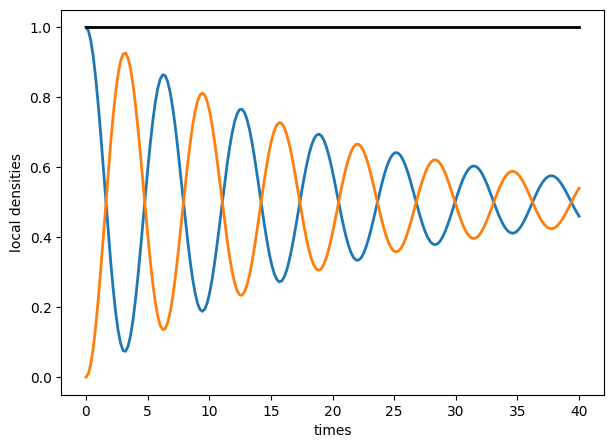

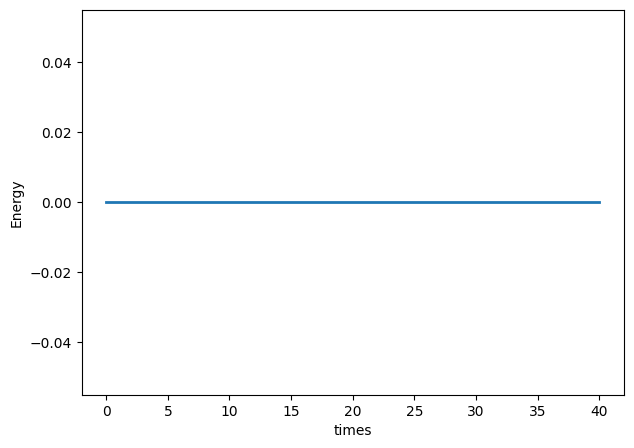

In [110]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# plot
for i in range(0,len(result.expect)-1):
    ax.plot(times, result.expect[i], linewidth=2.0)
    
# get the total particle number
# get the sum of the local densities
n_tot = np.sum(result.expect, axis=0)
ax.plot(times, n_tot, c='black', linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("local densities")

#plt.savefig("../plots/densities_L={}_Jc={}.pdf".format(L,J_contact))

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(times, result.expect[-1], linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("Energy")



Text(50.722222222222214, 0.5, 'densities')

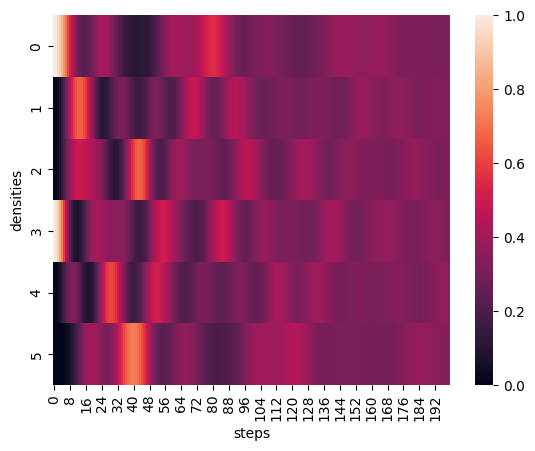

In [123]:
xt = np.linspace(0,max_t,5)
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1])
ax.set_xlabel("steps")
ax.set_ylabel("densities")


# With Gaussian initial state

In [112]:
L = 6 # Num of sites
gamma = 0.1 # the dephasing term for the collapse operators
max_t = 30 # maximum time
tsteps = 300 # number of time steps
J = np.ones(L) # interaction
J_contact = 1.0
# Here we could place a a point contact if we want
J[L-4] = J_contact
J[L-3] = J_contact
collapse_op = "number" # either "number" or "ladder"

centered_in = 2 # which site the gaussian wave packet is centered at
band_width = 0.7 # bandwidth og wave packet. Higher number means less localized
K0 = 2.0 # initial velocity of the wave packet this does not matter here i think


Quantum object: dims=[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape=(64, 64), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.  -0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  0.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.  -0.5  0. ]
 [ 0.   0.   0.  ... -0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]]

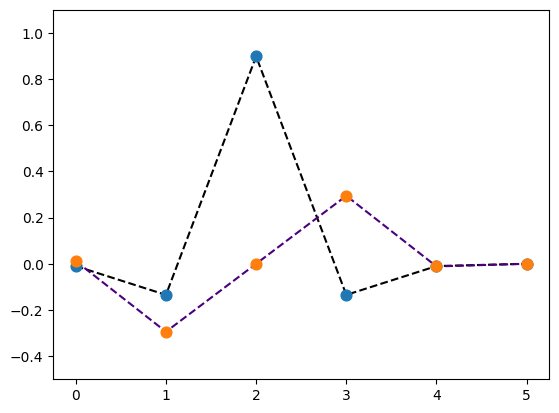

In [113]:
# initialize initial state
str_list, basis_list = get_1p_basis(L)
initial_condition = gen_gauss_init(centered_in,band_width, L,k0=K0)

plt.plot()
plt.scatter(range(0,L),initial_condition.real, zorder=7, s=60)
plt.plot(range(0,L),initial_condition.real, c='black', linestyle='dashed')

plt.scatter(range(0,L),initial_condition.imag, zorder=7, s=60)
plt.plot(range(0,L),initial_condition.imag, c='indigo', linestyle='dashed')

plt.ylim(-0.5,1.1)

psi0 = get_initial_state(initial_condition, basis_list)
rho = ket2dm(psi0)

# create the fermion operator list
c_list = [fdestroy(L,i) for i in range(0,L)]

# create the hamiltonian
H = get_thight_binding_hamiltonian(c_list, L,J)

# get the operators needed for lindbladian 
collapse_ops, expect_ops = create_lindblad_op(L, c_list ,collapse_op)
# add the energy to also track it
expect_ops.append(H)

H

In [114]:
times = np.linspace(0.0, max_t, tsteps)
result = mesolve(H, rho, times, c_ops=collapse_ops , e_ops=expect_ops)

result

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0001480579376220703
    preparation time: 0.0005309581756591797
    run time: 0.09937500953674316
    solver: 'Master Equation Evolution'
    num_collapse: 6
  Time interval: [0.0, 30.0] (300 steps)
  Number of e_ops: 7
  State not saved.
>

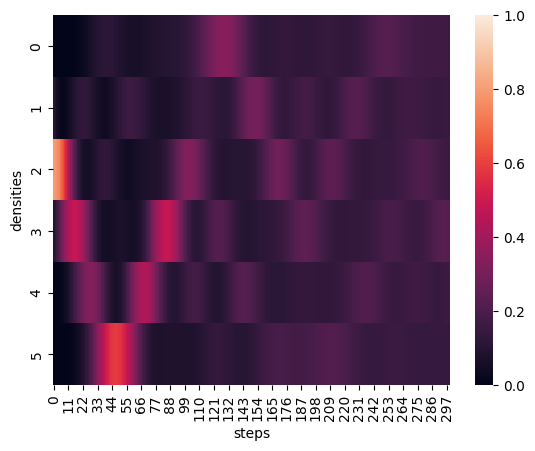

In [115]:
xt = np.linspace(0,max_t,5)
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1], vmin=0, vmax=1)
ax.set_xlabel("steps")
ax.set_ylabel("densities")

plt.savefig("../plots/trajectories_L={}_Jc={}_bw={}.png".format(L,J_contact,band_width))


Text(0, 0.5, 'Energy')

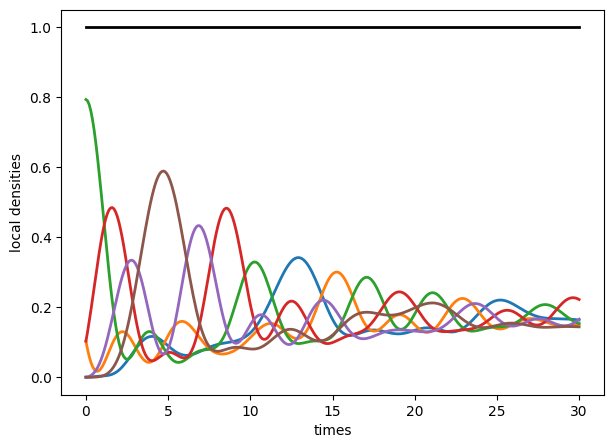

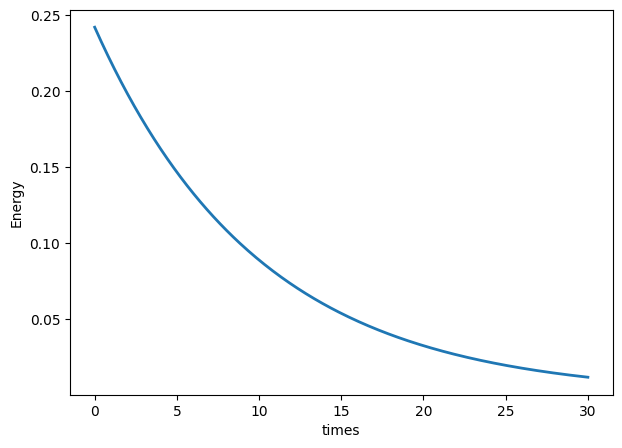

In [116]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# plot
for i in range(0,len(result.expect)-1):
    ax.plot(times, result.expect[i], linewidth=2.0)
    
# get the total particle number
# get the sum of the local densities remember that at -1 we have the energy
n_tot = np.sum(result.expect[:-1], axis=0)
ax.plot(times, n_tot, c='black', linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("local densities")

plt.savefig("../plots/densities_L={}_Jc={}_bw={}.pdf".format(L,J_contact,band_width))

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(times, result.expect[-1], linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("Energy")

